# Project 2 - Wine labels and Classification

Let's try constructing a system to label tasting notes by wine variety based on their reviews.

## Part 1

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

### Load and Preprocess Text

In [2]:
train = pd.read_parquet("/data/wine-train.parquet")
test = pd.read_parquet("/data/wine-test.parquet")

In [3]:
train["wine_variant"].value_counts()

Pinot Noir            38471
Cabernet Sauvignon    30234
Chardonnay            19443
Syrah                 13704
Riesling               9683
Zinfandel              8327
Merlot                 5522
Sauvignon Blanc        5113
Name: wine_variant, dtype: int64

In [4]:
train.head()

,review_text,wine_variant
0,Rich smoky dark cherry nose very intense fruit...,Pinot Noir
1,Had this at Corton Restaurant in NYC. First of...,Syrah
2,"Nose is very tart, with a layer of sweet fruit...",Pinot Noir
3,Beautiful golden color. Discrete perfumed nose...,Chardonnay
4,Please take the time to decant: you will not b...,Pinot Noir


### Collect candidate term phrases

In [5]:
import spacy
from spacy.matcher import Matcher

In [6]:
nlp = spacy.load(
    "en_core_web_sm", exclude=["parser", "ner", "lemmatizer", "attribute_ruler"]
)

In [7]:
matcher = Matcher(nlp.vocab)
matcher.add(
    "Term",
    [
        [
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP"]}},
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP", "HYPH"]}, "OP": "*"},
            {"TAG": {"IN": ["NN", "NNS", "NNP"]}},
        ]
    ],
)

In [8]:
def get_phrases(doc):
    spans = matcher(doc, as_spans=True)
    return [tuple(tok.norm_ for tok in span) for span in spans]

In [9]:
candidates = list(
    concat(map(get_phrases, nlp.pipe(tqdm(train["review_text"]), batch_size=20, n_process=4)))
)

  0%|          | 0/130497 [00:00<?, ?it/s]

In [10]:
import pickle

with open("cands.pkl", "wb") as out:
    pickle.dump(candidates, out)

In [11]:
from collections import defaultdict
import nltk

freqs = defaultdict(nltk.FreqDist)
for c in candidates:
    freqs[len(c)][c] += 1

### Extract terms

In [12]:
def get_subterms(term):
    k = len(term)
    for m in range(k - 1, 1, -1):
        yield from nltk.ngrams(term, m)


def c_value(F, theta):

    termhood = nltk.FreqDist()
    longer = defaultdict(list)

    for k in sorted(F, reverse=True):
        for term in F[k]:
            if term in longer:
                discount = sum(longer[term]) / len(longer[term])
            else:
                discount = 0
            c = np.log2(k) * (F[k][term] - discount)
            if c > theta:
                termhood[term] = c
                for subterm in get_subterms(term):
                    if subterm in F[len(subterm)]:
                        longer[subterm].append(F[k][term])
    return termhood

In [13]:
terms = c_value(freqs, theta=150)

In [14]:
terms.most_common(10)

[(('long', 'finish'), 6530.0),
 (('red', 'fruit'), 6447.888888888889),
 (('dark', 'fruit'), 4986.666666666667),
 (('black', 'cherry'), 4689.75),
 (('black', 'fruit'), 3451.0),
 (('red', 'fruits'), 3019.0),
 (('medium', 'finish'), 2804.0),
 (('good', 'acidity'), 2649.0),
 (('last', 'bottle'), 2376.0),
 (('medium', 'body'), 2283.0)]

In [15]:
terms.most_common()[-10:]

[(('crisp', 'finish'), 153.0),
 (('tart', 'raspberry'), 153.0),
 (('good', 'dose'), 153.0),
 (('pencil', 'shavings'), 153.0),
 (('tart', 'berry'), 153.0),
 (('vanilla', 'nose'), 153.0),
 (('oregon', 'pinot', 'noir'), 152.15640006923098),
 (('apple', 'fruit'), 152.0),
 (('earth', 'tones'), 152.0),
 (('tart', 'plum'), 151.0)]

In [16]:
with open('terms.txt', 'w') as f:
    for term in terms:
        print(' '.join(term), file=f)

### Multi-word Tokenizer

In [17]:
from spacy.matcher import PhraseMatcher
from spacy.util import filter_spans

In [18]:
nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)
phraser = PhraseMatcher(nlp.vocab, attr="LOWER")

In [19]:
with open('terms.txt', 'r') as f:
    phraser.add("TERM", [nlp.tokenizer(t.strip()) for t in f])

In [20]:
def tokenize(text, sep="_"):
    doc = nlp.tokenizer(text)
    with doc.retokenize() as r:
        for span in filter_spans(phraser(doc, as_spans=True)):
            r.merge(span)
    return [t.norm_.replace(" ", sep) for t in doc if not t.is_space and not t.is_punct]

In [21]:
train["tokens"] = train["review_text"].progress_apply(tokenize)
test["tokens"] = test["review_text"].progress_apply(tokenize)

  0%|          | 0/130497 [00:00<?, ?it/s]

  0%|          | 0/32625 [00:00<?, ?it/s]

### Linear Classifier

In [24]:
import fasttext
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats.distributions import loguniform, randint, uniform
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score

In [25]:
sgd = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier(random_state=321))
sgd.fit(train["tokens"], train["wine_variant"])
print(classification_report(test["wine_variant"], sgd.predict(test["tokens"])))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.70      0.81      0.75      7558
        Chardonnay       0.78      0.87      0.82      4861
            Merlot       0.81      0.34      0.47      1381
        Pinot Noir       0.81      0.83      0.82      9618
          Riesling       0.82      0.76      0.79      2421
   Sauvignon Blanc       0.79      0.67      0.72      1278
             Syrah       0.65      0.59      0.62      3426
         Zinfandel       0.72      0.57      0.64      2082

          accuracy                           0.76     32625
         macro avg       0.76      0.68      0.70     32625
      weighted avg       0.76      0.76      0.75     32625



### Hyperparameter Search

In [26]:
search = RandomizedSearchCV(
    sgd,
    {
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
        "sgdclassifier__average": [True, False]
    },
    n_iter=20,
    n_jobs=-1,
    scoring="f1_weighted",
)

search.fit(train["tokens"], train["wine_variant"])
search.best_score_, search.best_params_

(0.7554503197401312,
 {'sgdclassifier__alpha': 2.0814039028545628e-05,
  'sgdclassifier__average': True})

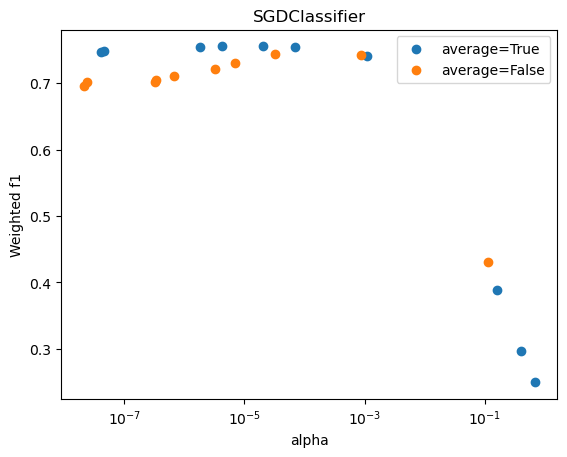

In [27]:
cv_results = pd.DataFrame(search.cv_results_)
plt.scatter(
    cv_results.query("param_sgdclassifier__average==True")[
        "param_sgdclassifier__alpha"
    ],
    cv_results.query("param_sgdclassifier__average==True")["mean_test_score"],
    label="average=True",
)
plt.scatter(
    cv_results.query("param_sgdclassifier__average==False")[
        "param_sgdclassifier__alpha"
    ],
    cv_results.query("param_sgdclassifier__average==False")["mean_test_score"],
    label="average=False",
)
plt.semilogx()
plt.title("SGDClassifier")
plt.xlabel("alpha")
plt.ylabel("Weighted f1")
plt.legend()
plt.show()

In [28]:
sgd.set_params(**search.best_params_)
sgd.fit(train["tokens"], train["wine_variant"])
print(classification_report(test["wine_variant"], sgd.predict(test["tokens"])))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.68      0.84      0.75      7558
        Chardonnay       0.83      0.85      0.84      4861
            Merlot       0.86      0.33      0.48      1381
        Pinot Noir       0.77      0.87      0.82      9618
          Riesling       0.85      0.77      0.81      2421
   Sauvignon Blanc       0.88      0.64      0.74      1278
             Syrah       0.75      0.55      0.63      3426
         Zinfandel       0.86      0.53      0.66      2082

          accuracy                           0.76     32625
         macro avg       0.81      0.67      0.71     32625
      weighted avg       0.77      0.76      0.76     32625



I decided to use a linear classifier with SGD, where the loss function "hinge", gives a linear SVM. The pre-processing was done with a multi-word tokenizer which also improved the performance compared to a simple tokenizer, as well as FastText. The model was also tuned to have the average parameter set to True, and as well as the optimized regularization term alpha. With these adjustments the macro-averaged F1 score(0.71) already performed better than the tuned MNB model(0.68). 

## Part 2

In [29]:
coef = sgd.named_steps["sgdclassifier"].coef_
vocab = sgd.named_steps["countvectorizer"].get_feature_names_out()

### Model Coefficients

In [30]:
ranked = np.argsort(coef, axis=1)
for i in range(-1, -26, -1):
    print(f"{vocab[ranked[0,i]]:15s} {coef[0,ranked[0,i]]:6.3f}")
print()
for i in range(25):
    print(f"{vocab[ranked[0,i]]:15s} {coef[0,ranked[0,i]]:6.3f}")

cabernet         5.846
cabs             5.403
cab              5.268
napa_cab         5.137
cabernet_sauvignon  5.120
cali_cab         5.014
california_cab   4.571
california_cabernet  3.979
nice_cab         3.965
napa_cabernet    3.672
cassis           3.226
caymus           3.073
cs               2.755
napa             2.735
dunn             2.711
montelena        2.675
cabernets        2.636
%_cabernet_sauvignon  2.612
bordeaux         2.612
quilceda         2.580
rutherford       2.413
creme_de_cassis  2.404
blackcurrant     2.377
black_currant    2.356
mountain         2.265

merlot          -5.562
pinot           -4.620
syrah           -4.484
zin             -4.259
merlots         -4.159
pinots          -3.892
pinot_noir      -3.693
zins            -3.664
chardonnay      -3.481
zinfandel       -3.409
pn              -3.382
hermitage       -3.262
syrahs          -3.206
burg            -3.088
chard           -3.076
burgundy        -2.973
oregon_pinot    -2.968
burgundian      -2.96

We can see that for Cab the highest coefficients words are ones that describe Cab. The names in the top 25 coefficients are brands that specialize in that as well. Let's look at ones that have a lower Recall score.

In [31]:
ranked = np.argsort(coef, axis=1)
for i in range(-1, -26, -1):
    print(f"{vocab[ranked[2,i]]:15s} {coef[2,ranked[2,i]]:6.3f}")
print()
for i in range(25):
    print(f"{vocab[ranked[2,i]]:15s} {coef[2,ranked[2,i]]:6.3f}")

merlot           9.580
merlots          7.231
%_merlot         3.360
paloma           2.353
bank             2.308
havens           2.254
pride            1.792
foley            1.638
pomerol          1.576
italian          1.543
januik           1.428
acetone          1.403
emilion          1.326
midweight        1.325
chocolate_notes  1.274
oakiness         1.266
tuscan           1.260
rounds           1.239
plummy           1.237
reds             1.214
cobbler          1.203
cocoa            1.203
timing           1.156
confirmed        1.153
plums            1.150

pinot           -3.163
syrah           -2.730
zin             -2.620
cabs            -2.501
pinot_noir      -2.407
cabernet        -2.403
cabernet_sauvignon -2.318
chardonnay      -2.302
napa_cab        -2.277
zinfandel       -2.162
cali_cab        -1.936
burgundy        -1.935
cab             -1.880
pinots          -1.867
citrus          -1.781
california_cab  -1.737
chard           -1.697
zins            -1.522
white  

After reviewing all 8 wine varieties, the features with the highest coefficients are relevant to their wine type. This is surprising for the ones with the lower recall score because I would think it would be classified more correctly. This might be due to the class imbalance, where Cab, Pinot, and Chardonnay have significantly more observations.  

## Part 3

### Confusion Matrix

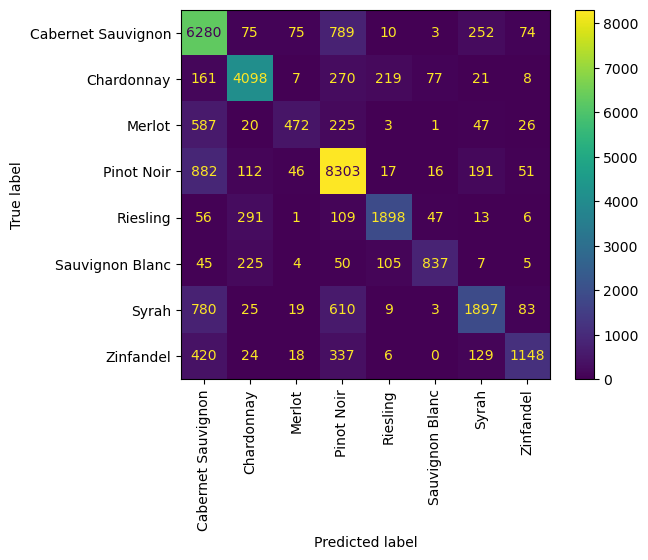

In [121]:
ConfusionMatrixDisplay.from_estimator(
    sgd, test["tokens"], test["wine_variant"], xticks_rotation=90
)

For Merlot, we can see that it reflects the very low recall score from our classification report. A large portion of Merlot is being classified as Cabernet Sauivgnon. We can try to create a new label that covers both Cabernet/Merlot to see if we can get better performance. However, if this label covers both types of wine, I'm curious to know how we would be able to use that information since they are two distinct wine types.

### Relabel, Train/Test

In [146]:
train['wine_variant'] = train['wine_variant'].replace('Merlot', 'Cabernet/Merlot')
train['wine_variant'] = train['wine_variant'].replace('Cabernet Sauvignon', 'Cabernet/Merlot')

In [147]:
test['wine_variant'] = test['wine_variant'].replace('Merlot', 'Cabernet/Merlot')
test['wine_variant'] = test['wine_variant'].replace('Cabernet Sauvignon', 'Cabernet/Merlot')

In [152]:
sgd = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier(random_state=321, average = True))
sgd.fit(train["tokens"], train["wine_variant"])
print(classification_report(test["wine_variant"], sgd.predict(test["tokens"])))

                 precision    recall  f1-score   support

Cabernet/Merlot       0.72      0.87      0.79      8939
     Chardonnay       0.84      0.84      0.84      4861
     Pinot Noir       0.78      0.85      0.82      9618
       Riesling       0.84      0.76      0.80      2421
Sauvignon Blanc       0.86      0.65      0.74      1278
          Syrah       0.79      0.52      0.62      3426
      Zinfandel       0.89      0.52      0.65      2082

       accuracy                           0.78     32625
      macro avg       0.82      0.71      0.75     32625
   weighted avg       0.79      0.78      0.78     32625



We can see an improvement of 0.75 macro-average F1 score with the new labels. Let's try to tune the model to see if we can get past 0.75

In [153]:
search = RandomizedSearchCV(
    sgd,
    {
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=20,
    n_jobs=-1,
    scoring="f1_weighted",
)

search.fit(train["tokens"], train["wine_variant"])
search.best_score_, search.best_params_

(0.7792001017454722, {'sgdclassifier__alpha': 1.0071075781375284e-05})

In [154]:
sgd.set_params(**search.best_params_)
sgd.fit(train["tokens"], train["wine_variant"])
print(classification_report(test["wine_variant"], sgd.predict(test["tokens"])))

                 precision    recall  f1-score   support

Cabernet/Merlot       0.73      0.86      0.79      8939
     Chardonnay       0.86      0.83      0.84      4861
     Pinot Noir       0.77      0.86      0.81      9618
       Riesling       0.84      0.78      0.81      2421
Sauvignon Blanc       0.87      0.65      0.75      1278
          Syrah       0.78      0.53      0.63      3426
      Zinfandel       0.87      0.53      0.66      2082

       accuracy                           0.78     32625
      macro avg       0.82      0.72      0.76     32625
   weighted avg       0.79      0.78      0.78     32625



Using the new set of labels, we were able to get a slight improvement of our macro-averaged F1 score.